In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np

from src.pipeline import PipelineConfig, run_pipeline

In [2]:
cfg = PipelineConfig(
    gpx_path="../data/Chianti course.gpx",
    elevation_floor_m=200.0,
    savgol_window_length=13,
    savgol_polyorder=3,
    llm_model="gpt-4.1-mini",
    llm_max_output_tokens=3000,
)

res = run_pipeline(cfg)
res.strategy_data.keys()
res.strategy_tables.keys()
res.strategy_tables["pacing_chunks"].head()
res.strategy_tables["critical_sections"].head()

,label,start_km,end_km,gain_m,avg_gradient_pct,effort_rpe,effort_hr_percent_max,notes
0,Climb #2,4.3,5.6,131,10.7,5,80-85%,"Approach climb with steady pacing, use poles i..."
1,Climb #4,21.0,22.5,106,5.9,4-5,75-85%,"Target power hiking cadence, use climb to rees..."
2,Climb #3,48.9,50.1,125,9.0,5-6,80-88%,This climb is early in late race phase; manage...
3,Climb #1,53.5,54.4,143,14.5,6,85-90%,Steepest and steep climb late in race; adopt p...
4,Climb #5,57.3,57.9,104,13.3,6,85-90%,Short but steep; maintain controlled effort; a...


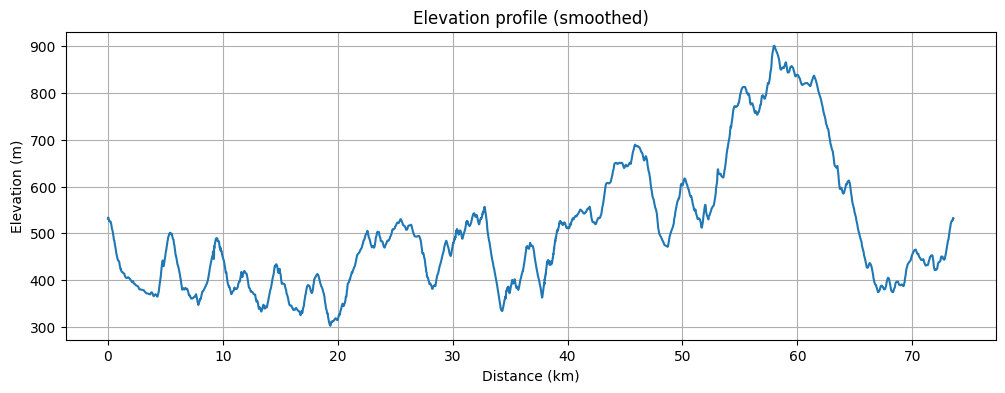

In [3]:
plt.figure(figsize=(12,4))
plt.plot(res.df_gpx["cum_distance"]/1000, res.df_gpx["elev_smooth"])
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Elevation profile (smoothed)")
plt.grid(True)
plt.show()

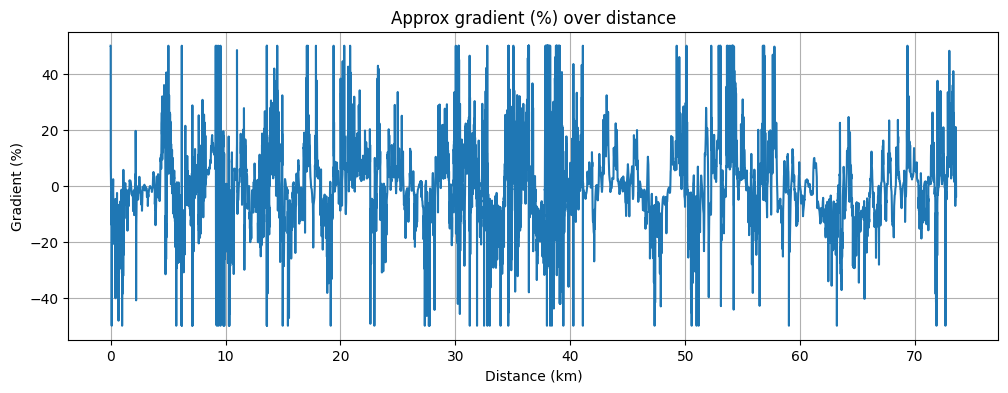

In [4]:
dist = res.df_gpx["cum_distance"].to_numpy(dtype=float)
elev = res.df_gpx["elev_smooth"].to_numpy(dtype=float)

# compute gradient using delta method with a floor on dx
dx = np.diff(dist)
dx = np.where(dx <= 1e-3, 1e-3, dx)  # 1mm floor (effectively removes divide-by-zero)
de = np.diff(elev)

grad_pct = (de / dx) * 100.0
grad_pct = np.concatenate([[grad_pct[0]], grad_pct])  # align length
grad_pct = np.clip(grad_pct, -50, 50)

plt.figure(figsize=(12,4))
plt.plot(dist/1000, grad_pct)
plt.xlabel("Distance (km)")
plt.ylabel("Gradient (%)")
plt.title("Approx gradient (%) over distance")
plt.grid(True)
plt.show()

In [5]:
res.overview_df

,distance_km,total_gain_m,total_loss_m,num_segments
0,73.6,2977,2976,123


In [6]:
res.segments_df.head()

,type,start_km,end_km,distance_km,gain_m,loss_m,avg_gradient_pct
0,descent_moderate,0.00,0.16,0.16,0.0,6.168426,-6.925076
1,descent_steep,0.18,0.94,0.76,0.0,84.557996,-11.898531
2,descent_moderate,0.96,1.30,0.34,0.0,24.055806,-4.977796
3,runnable,1.32,2.10,0.78,0.0,19.748530,-2.583734
5,runnable,2.12,4.30,2.18,0.0,31.083225,-0.739933


In [7]:
res.climbs_df.head()

,type,start_km,end_km,distance_km,gain_m,avg_gradient_pct
167,climb_steep,53.54,54.42,0.88,143.247597,14.456030
7,climb_steep,4.32,5.58,1.26,130.604842,10.733868
148,climb_steep,48.86,50.12,1.26,125.154677,9.035952
58,climb_moderate,20.96,22.54,1.58,106.122910,5.943827
177,climb_steep,57.28,57.94,0.66,103.506830,13.301923


In [8]:
res.strategy_tables.keys()

dict_keys(['pacing_chunks', 'critical_sections', 'fueling_plan', 'mental_cues'])

In [9]:
res.strategy_tables["pacing_chunks"].head()

,start_km,end_km,terrain_summary,effort_rpe,effort_hr_percent_max,key_focus
0,0.0,7.9,Initial descents and runnable terrain with som...,3-4,75-80%,"Use descents to reduce heart rate, keep climbi..."
1,8.0,22.5,Alternating runnable terrain with moderate and...,4-5,78-85%,"Maintain effort on climbs, recover on descents..."
2,22.6,50.0,Mixed runnable and climbing sections with mode...,4-5,75-85%,"Preserve energy, steady pacing, focus on hydra..."
3,50.1,60.0,Key steep climbs with short runnable and desce...,5-6,80-90%,"Steady power hiking on climbs, focused fueling..."
4,60.1,73.6,Final runnable sections with moderate technica...,5-6,82-90%,Conserve mental focus for final climbing effor...


In [10]:
res.strategy_tables["critical_sections"].head()

,label,start_km,end_km,gain_m,avg_gradient_pct,effort_rpe,effort_hr_percent_max,notes
0,Climb #2,4.3,5.6,131,10.7,5,80-85%,"Approach climb with steady pacing, use poles i..."
1,Climb #4,21.0,22.5,106,5.9,4-5,75-85%,"Target power hiking cadence, use climb to rees..."
2,Climb #3,48.9,50.1,125,9.0,5-6,80-88%,This climb is early in late race phase; manage...
3,Climb #1,53.5,54.4,143,14.5,6,85-90%,Steepest and steep climb late in race; adopt p...
4,Climb #5,57.3,57.9,104,13.3,6,85-90%,Short but steep; maintain controlled effort; a...
